##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification with Model Garden

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification_with_model_garden"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification_with_model_garden.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification_with_model_garden.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification_with_model_garden.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial fine-tunes a Residual Network (ResNet) from the TensorFlow [Model Garden](https://github.com/tensorflow/models) package (`tensorflow-models`) to classify images in the [CIFAR](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

Model Garden contains a collection of state-of-the-art vision models, implemented with TensorFlow's high-level APIs. The implementations demonstrate the best practices for modeling, letting users to take full advantage of TensorFlow for their research and product development.

This tutorial uses a [ResNet](https://arxiv.org/pdf/1512.03385.pdf) model, a state-of-the-art image classifier. This tutorial uses the ResNet-18 model, a convolutional neural network with 18 layers.

This tutorial demonstrates how to:
1. Use models from the TensorFlow Models package.
2. Fine-tune a pre-built ResNet for image classification.
3. Export the tuned ResNet model.

## Setup

Install and import the necessary modules. This tutorial uses the `tf-models-nightly` version of Model Garden.

Note: Upgrading TensorFlow to 2.9 in Colab breaks GPU support, so this colab is set to run on CPU until the Colab runtimes are updated.

In [2]:
!pip uninstall -y opencv-python
!pip install -U -q "tensorflow>=2.9.0" "tf-models-official"

Import TensorFlow, TensorFlow Datasets, and a few helper libraries.

In [3]:
import pprint
import tempfile

from IPython import display
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

The `tensorflow_models` package contains the ResNet vision model, and the `official.vision.serving` model contains the function to save and export the tuned model.

In [4]:
import tensorflow_models as tfm

# These are not in the tfm public API for v2.9. They will be available in v2.10
from official.vision.serving import export_saved_model_lib
import official.core.train_lib

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


## Configure the ResNet-18 model for the Cifar-10 dataset

The CIFAR10 dataset contains 60,000 color images in mutually exclusive 10 classes, with 6,000 images in each class.

In Model Garden, the collections of parameters that define a model are called *configs*. Model Garden can create a config based on a known set of parameters via a [factory](https://en.wikipedia.org/wiki/Factory_method_pattern).

Use the `resnet_imagenet` factory configuration, as defined by `tfm.vision.configs.image_classification.image_classification_imagenet`. The configuration is set up to train ResNet to converge on [ImageNet](https://www.image-net.org/).

In [5]:
exp_config = tfm.core.exp_factory.get_exp_config('resnet_imagenet')
tfds_name = 'cifar10'
ds_info = tfds.builder(tfds_name ).info
ds_info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='gs://tensorflow-datasets/datasets/cifar10/3.0.2',
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multi

Adjust the model and dataset configurations so that it works with Cifar-10 (`cifar10`).

In [6]:
# Configure model
exp_config.task.model.num_classes = 10
exp_config.task.model.input_size = list(ds_info.features["image"].shape)
exp_config.task.model.backbone.resnet.model_id = 18

# Configure training and testing data
batch_size = 128

exp_config.task.train_data.input_path = ''
exp_config.task.train_data.tfds_name = tfds_name
exp_config.task.train_data.tfds_split = 'train'
exp_config.task.train_data.global_batch_size = batch_size

exp_config.task.validation_data.input_path = ''
exp_config.task.validation_data.tfds_name = tfds_name
exp_config.task.validation_data.tfds_split = 'test'
exp_config.task.validation_data.global_batch_size = batch_size


Adjust the trainer configuration.

In [7]:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]

if 'GPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'GPU'
elif 'TPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'TPU'
else:
  print('Running on CPU is slow, so only train for a few steps.')
  device = 'CPU'

if device=='CPU':
  train_steps = 20
  exp_config.trainer.steps_per_loop = 5
else:
  train_steps=5000
  exp_config.trainer.steps_per_loop = 100

exp_config.trainer.summary_interval = 100
exp_config.trainer.checkpoint_interval = train_steps
exp_config.trainer.validation_interval = 1000
exp_config.trainer.validation_steps =  ds_info.splits['test'].num_examples // batch_size
exp_config.trainer.train_steps = train_steps
exp_config.trainer.optimizer_config.learning_rate.type = 'cosine'
exp_config.trainer.optimizer_config.learning_rate.cosine.decay_steps = train_steps
exp_config.trainer.optimizer_config.learning_rate.cosine.initial_learning_rate = 0.1
exp_config.trainer.optimizer_config.warmup.linear.warmup_steps = 100

This may be broken in Colab.


Print the modified configuration.

In [8]:
pprint.pprint(exp_config.as_dict())

display.Javascript("google.colab.output.setIframeHeight('300px');")

{'runtime': {'all_reduce_alg': None,
             'batchnorm_spatial_persistent': False,
             'dataset_num_private_threads': None,
             'default_shard_dim': -1,
             'distribution_strategy': 'mirrored',
             'enable_xla': True,
             'gpu_thread_mode': None,
             'loss_scale': None,
             'mixed_precision_dtype': None,
             'num_cores_per_replica': 1,
             'num_gpus': 0,
             'num_packs': 1,
             'per_gpu_thread_count': 0,
             'run_eagerly': False,
             'task_index': -1,
             'tpu': None,
             'tpu_enable_xla_dynamic_padder': None,
             'worker_hosts': None},
 'task': {'differential_privacy_config': None,
          'evaluation': {'top_k': 5},
          'init_checkpoint': None,
          'init_checkpoint_modules': 'all',
          'losses': {'l2_weight_decay': 0.0001,
                     'label_smoothing': 0.0,
                     'loss_weight': 1.0,
         

<IPython.core.display.Javascript object>

Set up the distribution strategy.

In [9]:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]

if exp_config.runtime.mixed_precision_dtype == tf.float16:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

if 'GPU' in ''.join(logical_device_names):
  distribution_strategy = tf.distribute.MirroredStrategy()
elif 'TPU' in ''.join(logical_device_names):
  tf.tpu.experimental.initialize_tpu_system()
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='/device:TPU_SYSTEM:0')
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  print('Warning: this will be really slow.')
  distribution_strategy = tf.distribute.OneDeviceStrategy(logical_device_names[0])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


Create the `Task` object (`tfm.core.base_task.Task`) from the `config_definitions.TaskConfig`.

The `Task` object has all the methods necessary for building the dataset, building the model, and running training & evaluation. These methods are driven by `tfm.core.train_lib.run_experiment`.

In [10]:
with distribution_strategy.scope():
  model_dir = tempfile.mkdtemp()
  task = tfm.core.task_factory.get_task(exp_config.task, logging_dir=model_dir)

tf.keras.utils.plot_model(task.build_model(), show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [11]:
for images, labels in task.build_inputs(exp_config.task.train_data).take(1):
  print()
  print(f'images.shape: {str(images.shape):16}  images.dtype: {images.dtype!r}')
  print(f'labels.shape: {str(labels.shape):16}  labels.dtype: {labels.dtype!r}')


images.shape: (128, 32, 32, 3)  images.dtype: tf.float32
labels.shape: (128,)            labels.dtype: tf.int32


2022-05-20 01:21:20.170576: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Visualize the training data

The dataloader applies a z-score normalization using 
`preprocess_ops.normalize_image(image, offset=MEAN_RGB, scale=STDDEV_RGB)`, so the images returned by the dataset can't be directly displayed by standard tools. The visualization code needs to rescale the data into the [0,1] range.

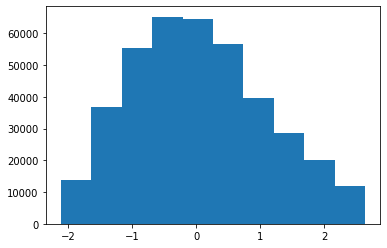

In [12]:
plt.hist(images.numpy().flatten());

Use `ds_info` (which is an instance of `tfds.core.DatasetInfo`) to lookup the text descriptions of each class ID.

In [13]:
label_info = ds_info.features['label']
label_info.int2str(1)

'automobile'

Visualize a batch of the data.

In [14]:
def show_batch(images, labels, predictions=None):
  plt.figure(figsize=(10, 10))
  min = images.numpy().min()
  max = images.numpy().max()
  delta = max - min

  for i in range(12):
    plt.subplot(6, 6, i + 1)
    plt.imshow((images[i]-min) / delta)
    if predictions is None:
      plt.title(label_info.int2str(labels[i]))
    else:
      if labels[i] == predictions[i]:
        color = 'g'
      else:
        color = 'r'
      plt.title(label_info.int2str(predictions[i]), color=color)
    plt.axis("off")

2022-05-20 01:21:22.167593: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


<Figure size 720x720 with 0 Axes>

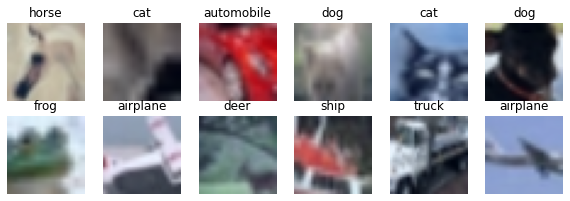

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in task.build_inputs(exp_config.task.train_data).take(1):
  show_batch(images, labels)

## Visualize the testing data

Visualize a batch of images from the validation dataset.

2022-05-20 01:21:23.933359: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


<Figure size 720x720 with 0 Axes>

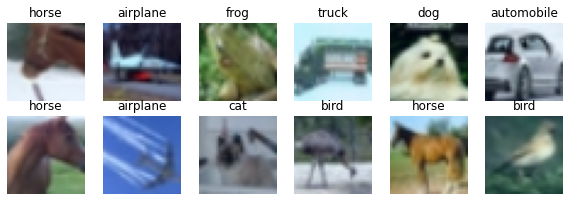

In [16]:
plt.figure(figsize=(10, 10));
for images, labels in task.build_inputs(exp_config.task.validation_data).take(1):
  show_batch(images, labels)

## Train and evaluate

In [17]:
model, eval_logs = tfm.core.train_lib.run_experiment(
    distribution_strategy=distribution_strategy,
    task=task,
    mode='train_and_eval',
    params=exp_config,
    model_dir=model_dir,
    run_post_eval=True)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


restoring or initializing model...
initialized model.
train | step:      0 | training until step 1000...


INFO:tensorflow:batch_all_reduce: 65 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 65 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 65 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 65 all-reduces with algorithm = nccl, num_packs = 1


train | step:    100 | steps/sec:    3.7 | output: 
    {'accuracy': 0.20179687,
     'learning_rate': 0.09990134,
     'top_5_accuracy': 0.7065625,
     'training_loss': 2.6765962}


saved checkpoint to /tmpfs/tmp/tmp0g394trt/ckpt-100.


train | step:    200 | steps/sec:   23.1 | output: 
    {'accuracy': 0.22,
     'learning_rate': 0.09960574,
     'top_5_accuracy': 0.74960935,
     'training_loss': 2.639689}


train | step:    300 | steps/sec:   30.5 | output: 
    {'accuracy': 0.26296875,
     'learning_rate': 0.09911436,
     'top_5_accuracy': 0.8015625,
     'training_loss': 2.2665164}


train | step:    400 | steps/sec:   30.8 | output: 
    {'accuracy': 0.2921875,
     'learning_rate': 0.09842916,
     'top_5_accuracy': 0.8153125,
     'training_loss': 2.1931498}


train | step:    500 | steps/sec:   30.9 | output: 
    {'accuracy': 0.30765626,
     'learning_rate': 0.09755283,
     'top_5_accuracy': 0.82640624,
     'training_loss': 2.1405349}


train | step:    600 | steps/sec:   30.8 | output: 
    {'accuracy': 0.32648438,
     'learning_rate': 0.096488826,
     'top_5_accuracy': 0.838125,
     'training_loss': 2.0971737}


train | step:    700 | steps/sec:   30.9 | output: 
    {'accuracy': 0.33273438,
     'learning_rate': 0.09524136,
     'top_5_accuracy': 0.8465625,
     'training_loss': 2.055499}


train | step:    800 | steps/sec:   30.9 | output: 
    {'accuracy': 0.34632814,
     'learning_rate': 0.09381534,
     'top_5_accuracy': 0.8510156,
     'training_loss': 2.030479}


train | step:    900 | steps/sec:   30.9 | output: 
    {'accuracy': 0.355,
     'learning_rate': 0.092216395,
     'top_5_accuracy': 0.85617185,
     'training_loss': 2.0079381}


train | step:   1000 | steps/sec:   30.9 | output: 
    {'accuracy': 0.36117187,
     'learning_rate': 0.090450846,
     'top_5_accuracy': 0.8575781,
     'training_loss': 1.9869858}
 eval | step:   1000 | running 78 steps of evaluation...


 eval | step:   1000 | eval time:    3.9 sec | output: 
    {'accuracy': 0.45693108,
     'top_5_accuracy': 0.92007214,
     'validation_loss': 1.7431049}
train | step:   1000 | training until step 2000...


train | step:   1100 | steps/sec:   14.0 | output: 
    {'accuracy': 0.373125,
     'learning_rate': 0.08852567,
     'top_5_accuracy': 0.8663281,
     'training_loss': 1.9581943}


train | step:   1200 | steps/sec:   30.9 | output: 
    {'accuracy': 0.37921876,
     'learning_rate': 0.08644843,
     'top_5_accuracy': 0.8588281,
     'training_loss': 1.9610095}


train | step:   1300 | steps/sec:   30.9 | output: 
    {'accuracy': 0.39257812,
     'learning_rate': 0.08422736,
     'top_5_accuracy': 0.87921876,
     'training_loss': 1.9058603}


train | step:   1400 | steps/sec:   30.9 | output: 
    {'accuracy': 0.39351562,
     'learning_rate': 0.081871204,
     'top_5_accuracy': 0.8763281,
     'training_loss': 1.9013312}


train | step:   1500 | steps/sec:   30.9 | output: 
    {'accuracy': 0.40015626,
     'learning_rate': 0.07938927,
     'top_5_accuracy': 0.88640624,
     'training_loss': 1.8696674}


train | step:   1600 | steps/sec:   31.0 | output: 
    {'accuracy': 0.4275,
     'learning_rate': 0.07679134,
     'top_5_accuracy': 0.8851563,
     'training_loss': 1.8287336}


train | step:   1700 | steps/sec:   30.8 | output: 
    {'accuracy': 0.42335936,
     'learning_rate': 0.07408768,
     'top_5_accuracy': 0.8875781,
     'training_loss': 1.8214478}


train | step:   1800 | steps/sec:   30.9 | output: 
    {'accuracy': 0.43171874,
     'learning_rate': 0.071288966,
     'top_5_accuracy': 0.89171875,
     'training_loss': 1.7993746}


train | step:   1900 | steps/sec:   30.9 | output: 
    {'accuracy': 0.43421876,
     'learning_rate': 0.068406224,
     'top_5_accuracy': 0.89515626,
     'training_loss': 1.7842441}


train | step:   2000 | steps/sec:   30.7 | output: 
    {'accuracy': 0.44421875,
     'learning_rate': 0.06545085,
     'top_5_accuracy': 0.8919531,
     'training_loss': 1.7745165}
 eval | step:   2000 | running 78 steps of evaluation...


 eval | step:   2000 | eval time:    0.9 sec | output: 
    {'accuracy': 0.5608974,
     'top_5_accuracy': 0.947516,
     'validation_loss': 1.4589052}
train | step:   2000 | training until step 3000...


train | step:   2100 | steps/sec:   23.9 | output: 
    {'accuracy': 0.44679686,
     'learning_rate': 0.062434502,
     'top_5_accuracy': 0.901875,
     'training_loss': 1.7431287}


train | step:   2200 | steps/sec:   30.9 | output: 
    {'accuracy': 0.44789064,
     'learning_rate': 0.059369065,
     'top_5_accuracy': 0.89703125,
     'training_loss': 1.7575699}


train | step:   2300 | steps/sec:   30.9 | output: 
    {'accuracy': 0.45890626,
     'learning_rate': 0.056266654,
     'top_5_accuracy': 0.9024219,
     'training_loss': 1.732562}


train | step:   2400 | steps/sec:   31.0 | output: 
    {'accuracy': 0.45632812,
     'learning_rate': 0.053139526,
     'top_5_accuracy': 0.8990625,
     'training_loss': 1.7404855}


train | step:   2500 | steps/sec:   30.9 | output: 
    {'accuracy': 0.47171876,
     'learning_rate': 0.049999997,
     'top_5_accuracy': 0.9059375,
     'training_loss': 1.6968014}


train | step:   2600 | steps/sec:   30.9 | output: 
    {'accuracy': 0.47679687,
     'learning_rate': 0.04686048,
     'top_5_accuracy': 0.90851563,
     'training_loss': 1.6774287}


train | step:   2700 | steps/sec:   30.9 | output: 
    {'accuracy': 0.4725,
     'learning_rate': 0.043733336,
     'top_5_accuracy': 0.906875,
     'training_loss': 1.6907151}


train | step:   2800 | steps/sec:   30.9 | output: 
    {'accuracy': 0.48476562,
     'learning_rate': 0.040630933,
     'top_5_accuracy': 0.9096875,
     'training_loss': 1.6499205}


train | step:   2900 | steps/sec:   30.9 | output: 
    {'accuracy': 0.4903125,
     'learning_rate': 0.037565507,
     'top_5_accuracy': 0.91296875,
     'training_loss': 1.644148}


train | step:   3000 | steps/sec:   30.9 | output: 
    {'accuracy': 0.49875,
     'learning_rate': 0.034549143,
     'top_5_accuracy': 0.9175,
     'training_loss': 1.6293072}
 eval | step:   3000 | running 78 steps of evaluation...


 eval | step:   3000 | eval time:    0.9 sec | output: 
    {'accuracy': 0.64933896,
     'top_5_accuracy': 0.96284056,
     'validation_loss': 1.227595}
train | step:   3000 | training until step 4000...


train | step:   3100 | steps/sec:   23.9 | output: 
    {'accuracy': 0.50773436,
     'learning_rate': 0.03159377,
     'top_5_accuracy': 0.92148435,
     'training_loss': 1.5991089}


train | step:   3200 | steps/sec:   31.0 | output: 
    {'accuracy': 0.51390624,
     'learning_rate': 0.028711034,
     'top_5_accuracy': 0.9199219,
     'training_loss': 1.5766236}


train | step:   3300 | steps/sec:   30.9 | output: 
    {'accuracy': 0.5179688,
     'learning_rate': 0.025912309,
     'top_5_accuracy': 0.9257031,
     'training_loss': 1.5648974}


train | step:   3400 | steps/sec:   30.9 | output: 
    {'accuracy': 0.5252344,
     'learning_rate': 0.023208654,
     'top_5_accuracy': 0.9253125,
     'training_loss': 1.5347563}


train | step:   3500 | steps/sec:   30.8 | output: 
    {'accuracy': 0.5271094,
     'learning_rate': 0.020610739,
     'top_5_accuracy': 0.9246875,
     'training_loss': 1.537352}


train | step:   3600 | steps/sec:   30.8 | output: 
    {'accuracy': 0.53882813,
     'learning_rate': 0.018128792,
     'top_5_accuracy': 0.9285156,
     'training_loss': 1.5100527}


train | step:   3700 | steps/sec:   30.8 | output: 
    {'accuracy': 0.5415625,
     'learning_rate': 0.015772644,
     'top_5_accuracy': 0.930625,
     'training_loss': 1.5032517}


train | step:   3800 | steps/sec:   30.8 | output: 
    {'accuracy': 0.54015625,
     'learning_rate': 0.01355157,
     'top_5_accuracy': 0.9295313,
     'training_loss': 1.495744}


train | step:   3900 | steps/sec:   31.0 | output: 
    {'accuracy': 0.5389063,
     'learning_rate': 0.011474336,
     'top_5_accuracy': 0.9286719,
     'training_loss': 1.4985079}


train | step:   4000 | steps/sec:   30.9 | output: 
    {'accuracy': 0.5586719,
     'learning_rate': 0.009549147,
     'top_5_accuracy': 0.93171877,
     'training_loss': 1.4675434}
 eval | step:   4000 | running 78 steps of evaluation...


 eval | step:   4000 | eval time:    0.9 sec | output: 
    {'accuracy': 0.6905048,
     'top_5_accuracy': 0.9709535,
     'validation_loss': 1.099941}
train | step:   4000 | training until step 5000...


train | step:   4100 | steps/sec:   24.0 | output: 
    {'accuracy': 0.5492188,
     'learning_rate': 0.0077836006,
     'top_5_accuracy': 0.935,
     'training_loss': 1.4759307}


train | step:   4200 | steps/sec:   31.0 | output: 
    {'accuracy': 0.5535156,
     'learning_rate': 0.0061846706,
     'top_5_accuracy': 0.93523437,
     'training_loss': 1.4548165}


train | step:   4300 | steps/sec:   30.9 | output: 
    {'accuracy': 0.5553125,
     'learning_rate': 0.0047586444,
     'top_5_accuracy': 0.92960936,
     'training_loss': 1.4575851}


train | step:   4400 | steps/sec:   31.0 | output: 
    {'accuracy': 0.5625,
     'learning_rate': 0.0035111725,
     'top_5_accuracy': 0.935,
     'training_loss': 1.4376304}


train | step:   4500 | steps/sec:   30.9 | output: 
    {'accuracy': 0.56328124,
     'learning_rate': 0.002447176,
     'top_5_accuracy': 0.93859375,
     'training_loss': 1.4372238}


train | step:   4600 | steps/sec:   31.0 | output: 
    {'accuracy': 0.56,
     'learning_rate': 0.0015708387,
     'top_5_accuracy': 0.9369531,
     'training_loss': 1.4337252}


train | step:   4700 | steps/sec:   30.9 | output: 
    {'accuracy': 0.55921876,
     'learning_rate': 0.0008856386,
     'top_5_accuracy': 0.9369531,
     'training_loss': 1.4402907}


train | step:   4800 | steps/sec:   31.0 | output: 
    {'accuracy': 0.5690625,
     'learning_rate': 0.00039426386,
     'top_5_accuracy': 0.94171876,
     'training_loss': 1.4211408}


train | step:   4900 | steps/sec:   31.0 | output: 
    {'accuracy': 0.576875,
     'learning_rate': 9.866357e-05,
     'top_5_accuracy': 0.93796873,
     'training_loss': 1.411213}


train | step:   5000 | steps/sec:   31.0 | output: 
    {'accuracy': 0.5769531,
     'learning_rate': 0.0,
     'top_5_accuracy': 0.9417969,
     'training_loss': 1.4006726}
 eval | step:   5000 | running 78 steps of evaluation...


 eval | step:   5000 | eval time:    0.9 sec | output: 
    {'accuracy': 0.7026242,
     'top_5_accuracy': 0.9781651,
     'validation_loss': 1.0504705}


saved checkpoint to /tmpfs/tmp/tmp0g394trt/ckpt-5000.


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


Print the `accuracy`, `top_5_accuracy`, and `validation_loss` evaluation metrics.

In [19]:
for key, value in eval_logs.items():
    print(f'{key:20}: {value.numpy():.3f}')

accuracy            : 0.703
top_5_accuracy      : 0.978
validation_loss     : 1.050


Run a batch of the processed training data through the model, and view the results

2022-05-20 01:24:46.088129: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_54824"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:212"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PROD

1/4 [======>.......................] - ETA: 7s

4/4 [==============================] - 3s 8ms/step


2022-05-20 01:24:48.739386: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


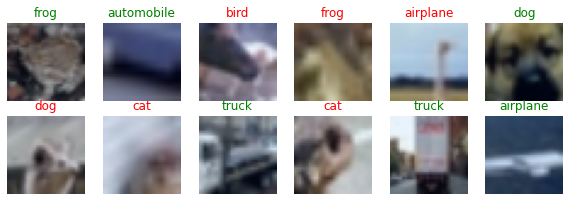

In [20]:
for images, labels in task.build_inputs(exp_config.task.train_data).take(1):
  predictions = model.predict(images)
  predictions = tf.argmax(predictions, axis=-1)

show_batch(images, labels, tf.cast(predictions, tf.int32))

if device=='CPU':
  plt.suptitle('The model was only trained for a few steps, it is not expected to do well.')

## Export a SavedModel

The `keras.Model` object returned by `train_lib.run_experiment` expects the data to be normalized by the dataset loader using the same mean and variance statiscics in `preprocess_ops.normalize_image(image, offset=MEAN_RGB, scale=STDDEV_RGB)`. This export function handles those details, so you can pass `tf.uint8` images and get the correct results.


In [21]:
# Saving and exporting the trained model
export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[32, 32],
    params=exp_config,
    checkpoint_path=tf.train.latest_checkpoint(model_dir),
    export_dir='./export/')

INFO:tensorflow:Assets written to: ./export/assets


INFO:tensorflow:Assets written to: ./export/assets


Test the exported model.

In [22]:
# Importing SavedModel
imported = tf.saved_model.load('./export/')
model_fn = imported.signatures['serving_default']

Visualize the predictions.

2022-05-20 01:25:02.297228: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


<Figure size 720x720 with 0 Axes>

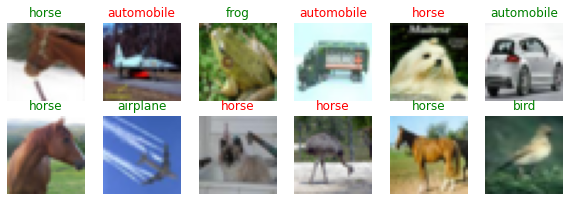

In [23]:
plt.figure(figsize=(10, 10))
for data in tfds.load('cifar10', split='test').batch(12).take(1):
  predictions = []
  for image in data['image']:
    index = tf.argmax(model_fn(image[tf.newaxis, ...])['logits'], axis=1)[0]
    predictions.append(index)
  show_batch(data['image'], data['label'], predictions)

  if device=='CPU':
    plt.suptitle('The model was only trained for a few steps, it is not expected to do better than random.')